**Lab 1 CT-221**: Predição de séries temporais


**Equipe**: Victor Hugo de Oliveira Bastos, Leonardo Antônio Lugarini, José Eduardo Teixeira Araújo, Marcel Versiani, Rafael Otero

>[Preparação dos dados](#scrollTo=PVReDV-SVMVX)

>>[Importando pacotes e dados](#scrollTo=efpR3GuWVMVc)

>>[Aplicando os modelos](#scrollTo=LHNzVtsrY7AG)

>>>[[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt](#scrollTo=FUZnaVtqVSCO)

>>>[[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt](#scrollTo=Uqu36GzdVYh8)

>>>[[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation](#scrollTo=4pekYAa4ae7l)

>>>[[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient](#scrollTo=H1UzQr-bVxzV)

>>>[[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization](#scrollTo=fbGBxtj_XKLv)

>>>[[6] 10-25-25-1, r = p = 25, Tanh / RMSprop](#scrollTo=ziJ-KWiOb50H)

>>[Analisando os resultados](#scrollTo=iA97S80t7h18)



 <a name='prep'></a>
#Preparação dos dados



<a name='imp'></a>
## Importando pacotes e dados

In [12]:
# Importing the necessary Python libraries
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode, iplot
import visualkeras
# Importing scipy.stats for Q-Q plots
import scipy.stats as stats
plt.style.use('ggplot')

# Importing train_test_split from sklearn.model_selection
from sklearn.model_selection import train_test_split

# Importing OrdinalEncoder from sklearn.compose and sklearn.preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OrdinalEncoder

# Importing KBinsDiscretizer from sklearn.preprocessing
from sklearn.preprocessing import KBinsDiscretizer

# Importing MinMaxScaler from sklearn.preprocessing
from sklearn.preprocessing import MinMaxScaler

# Importing KNeighborsClassifier from sklearn.neighbors
from sklearn.neighbors import KNeighborsClassifier

# Importing DecisionTreeClassifier from sklearn.tree
from sklearn.tree import DecisionTreeClassifier

# Importing GaussianNB from sklearn.naive_bayes
from sklearn.naive_bayes import GaussianNB

# Importing metrics from sklearn.metrics
from sklearn.metrics import (
    accuracy_score,
    recall_score,
    precision_score,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    classification_report,
    roc_curve,
    roc_auc_score
)

# Importing GridSearchCV from sklearn.model_selection
from sklearn.model_selection import GridSearchCV

# Importing PowerTransformer and FunctionTransformer from sklearn.preprocessing
from sklearn.preprocessing import PowerTransformer, FunctionTransformer

import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
#from keras.utils.vis_utils import plot_model
from keras.utils import plot_model
# Ignore warnings
import warnings
warnings.filterwarnings("ignore")


Por conveniência, optou-se por adquirir os dados a partir da leitura do Google Drive.

In [13]:
# Carregando os dados...

def carregar_dados(url):
  # URL dos arquivos CSV
  url_data = url
  # Extração do identificador do arquivo da URL
  identificador = url.split('/')[-2]
  # Construção do link de download direto do arquivo
  url_download = 'https://drive.google.com/uc?id=' + identificador

  #Retorna dataframe
  return pd.read_csv(url_download, on_bad_lines='skip', sep=',',parse_dates=['Date'], index_col=['Date'])


# URL dos arquivos CSV
url_data_embr = 'https://drive.google.com/file/d/1JkBgws5aVCpP9Xunv_51Pkhv8QdM6ZKT/view?usp=drive_link'
url_data_petr = 'httpsn://drive.google.com/file/d/1tvv9iIqA9bOpR31c545e59oOzbkXxmpv/view?usp=drive_link'
url_data_vale = 'https://drive.google.com/file/d/1JxYLJ9EQHnN0XGUmOBdd7as_EDsV9CKX/view?usp=drive_link'

embr = carregar_dados(url_data_embr)
petr = carregar_dados(url_data_petr)
vale = carregar_dados(url_data_vale)

companies = dict({'Petr':petr, 'Embr':embr, 'Vale':vale})

In [14]:
#Exibindo dataset
petr.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2018-01-02,16.990000,17.330000,16.980000,17.330000,6.917481,4488000
2018-01-03,17.240000,17.670000,17.209999,17.549999,7.005296,9771700
2018-01-04,17.670000,17.900000,17.629999,17.700001,7.065169,6816500
2018-01-05,17.690001,17.850000,17.600000,17.840000,7.121052,4646500
2018-01-08,17.639999,18.120001,17.610001,18.120001,7.232818,4763400


<a name='ana'></a>
## Aplicando os modelos

In [15]:
#Separando os últimos 90 registros
petr_close = petr[:-90]['Close']
embr_close = embr[:-90]['Close']
vale_close = vale[:-90]['Close']

In [16]:
date_index  = petr[-90:].index

<a name='ana'></a>
###[1] 10-15-1 --- r = 15, p = 0 e tanh / Levenberg-Marquardt

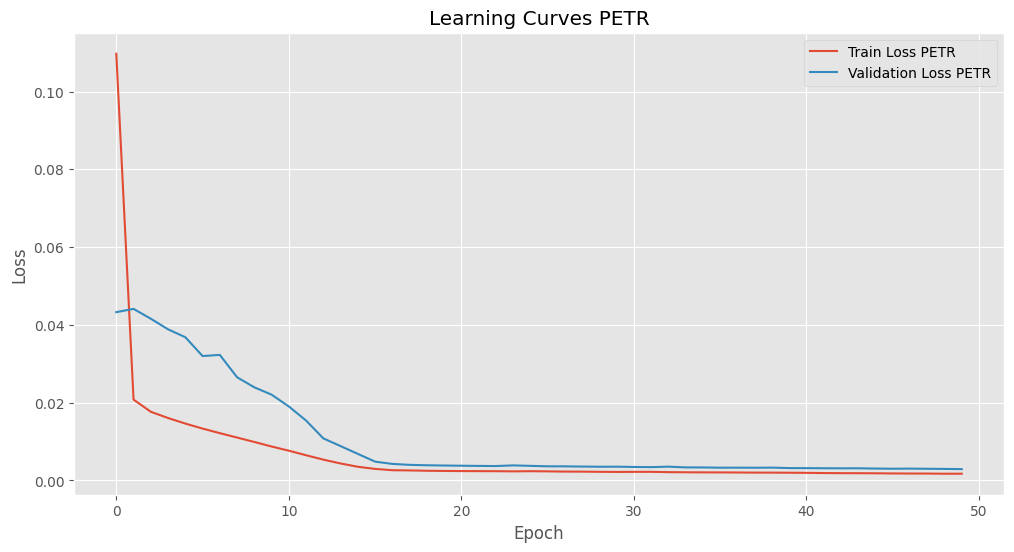

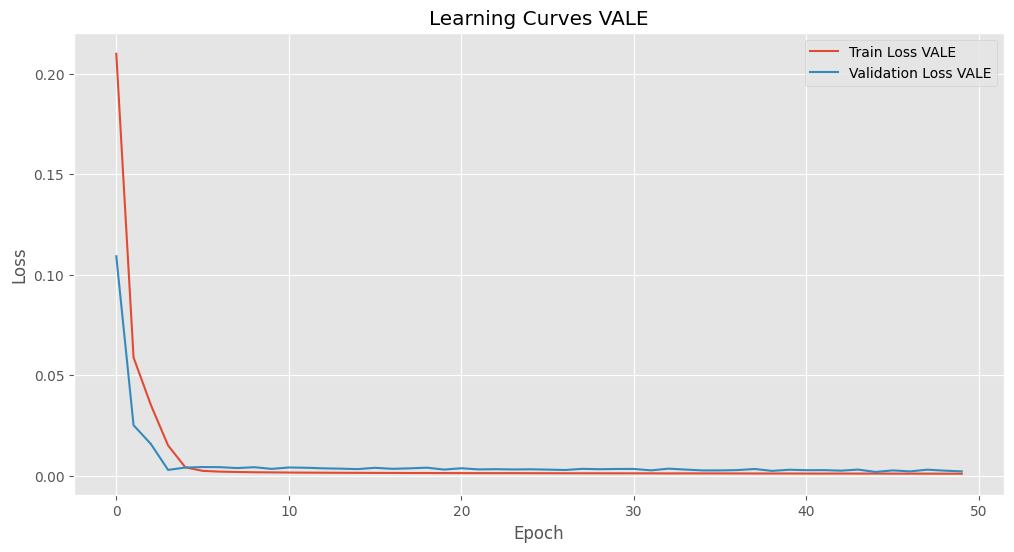

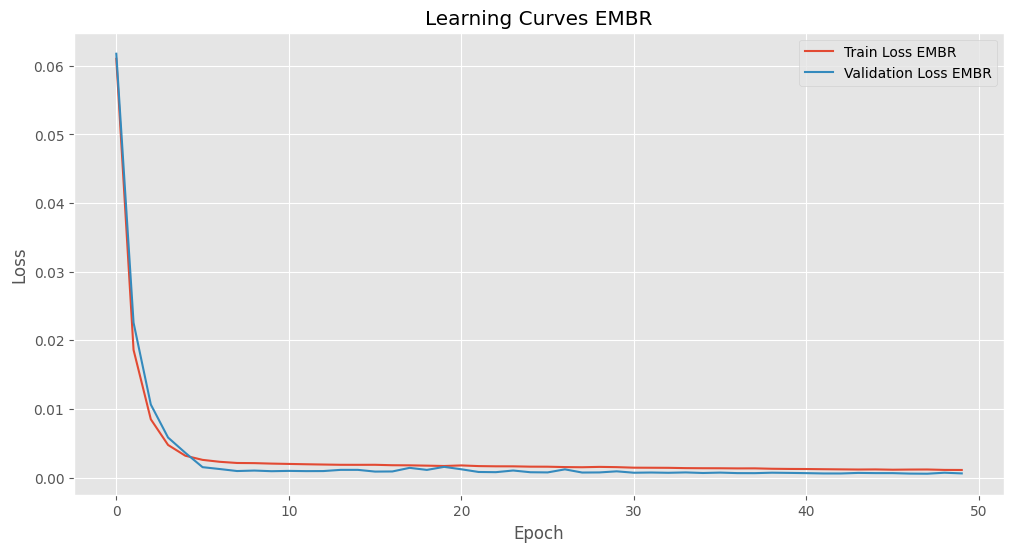

1/1 [==============================] - 0s 31ms/step


In [18]:
r_1 = 15
p_1 = 0

# Função para criar amostras NARMAX
def create_narmax_samples(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# Função para fazer previsões
def make_predictions(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_1 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_1 = MinMaxScaler()
normalized_data_1 = scaler_1.fit_transform(combined_data_1)

# Dividir os dados em treinamento e teste
train_size_1 = int(0.8 * normalized_data_1.shape[0])
train_data_1 = normalized_data_1[:train_size_1]
test_data_1 = normalized_data_1[train_size_1:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_1 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_1, y_train_1 = create_narmax_samples(train_data_1, sequence_length_1)
X_test_1, y_test_1 = create_narmax_samples(test_data_1, sequence_length_1)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR com learning curves
model_petr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_petr_1, X_train_1, y_train_1[:, 0], X_test_1, y_test_1[:, 0], label='PETR')

model_vale_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_vale_1, X_train_1, y_train_1[:, 1], X_test_1, y_test_1[:, 1], label='VALE')

model_embr_1 = create_narmax_model(r_1, p_1, sequence_length_1, normalized_data_1.shape[1])
train_narmax_model_with_learning_curves(model_embr_1, X_train_1, y_train_1[:, 2], X_test_1, y_test_1[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_1 = normalized_data_1[-sequence_length_1:, :]

predicted_1 = make_predictions([model_petr_1,
                              model_vale_1,
                              model_embr_1],
                              last_10_days_1, 90)

# Imprima as previsões
petr_predictions_1 = []
embr_predictions_1 = []
vale_predictions_1 = []

for i in predicted_1:
    petr_predictions_1.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_1.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_1.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))


In [ ]:
plot_model(model_petr_1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [19]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_1)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_1)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_1)

Previsão para os próximos 90 dias de PETR:
[27.390605719421746, 27.458389896324157, 27.521167638741076, 27.58983926207608, 27.67001677389264, 27.776977710010826, 27.896166494105934, 28.02214751677835, 28.151165497529508, 28.27951971199399, 28.41963077315253, 28.54559724752277, 28.664969703932822, 28.776962534065305, 28.882690501574277, 28.98403761159122, 29.081485776625634, 29.175907894807935, 29.267378526186764, 29.35607588746375, 29.44194905958128, 29.52427426450622, 29.602851463083685, 29.67772430022019, 29.74908372238177, 29.81715340971434, 29.88213340137279, 29.944200095520973, 30.003468060038507, 30.060033677427292, 30.113971507735968, 30.165354292475403, 30.21427113999641, 30.260816614263117, 30.305085279239655, 30.34718261011678, 30.387217719160795, 30.425283351798058, 30.461477709068237, 30.49588444370884, 30.528590845532893, 30.559675111664593, 30.58921725776589, 30.61729002534765, 30.643969792996288, 30.669322028071583, 30.693419472084404, 30.71632577385676, 30.7380991265973

<a name='ana'></a>
###[2] 10-10-10-1 --- r = 10, p = 10 e Relu / Levenberg-Marquardt

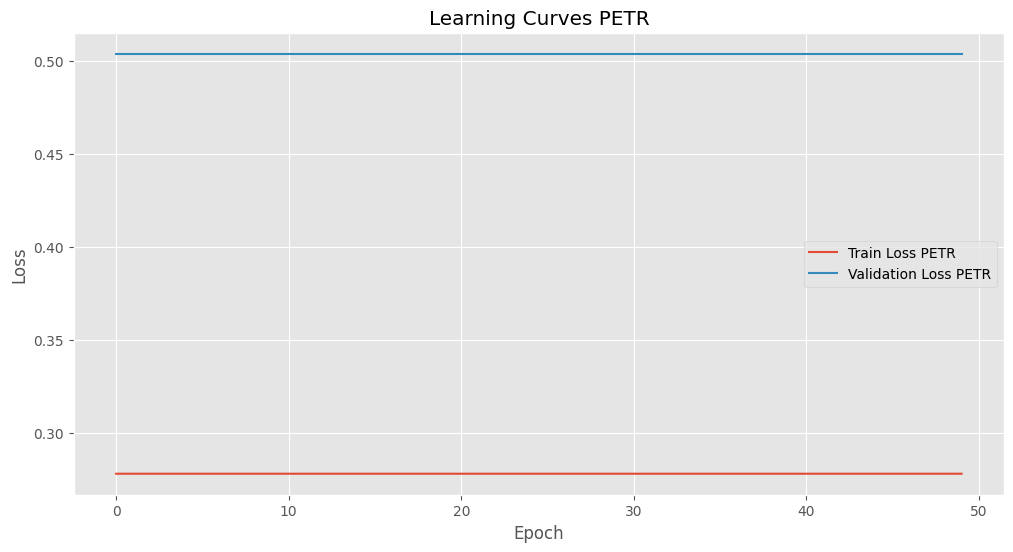

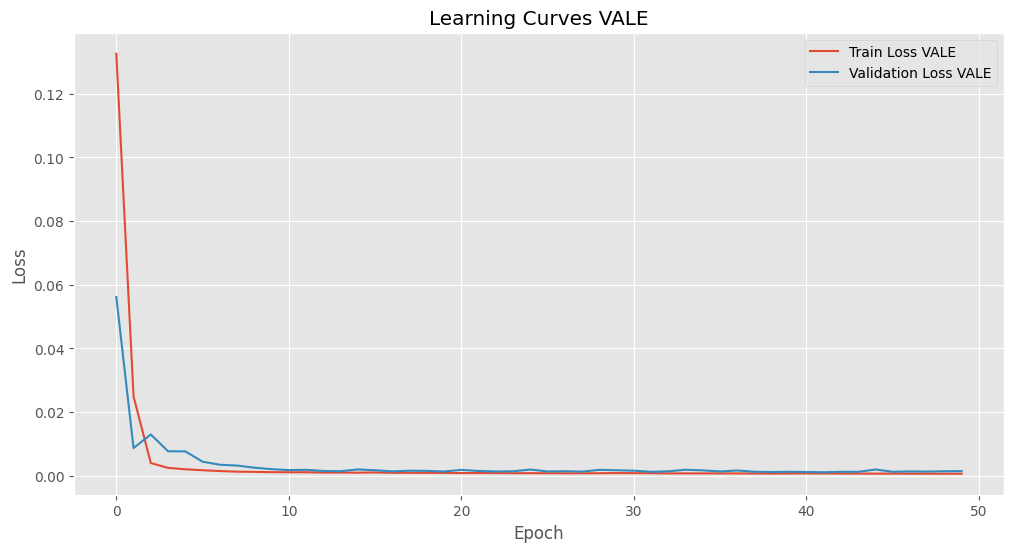

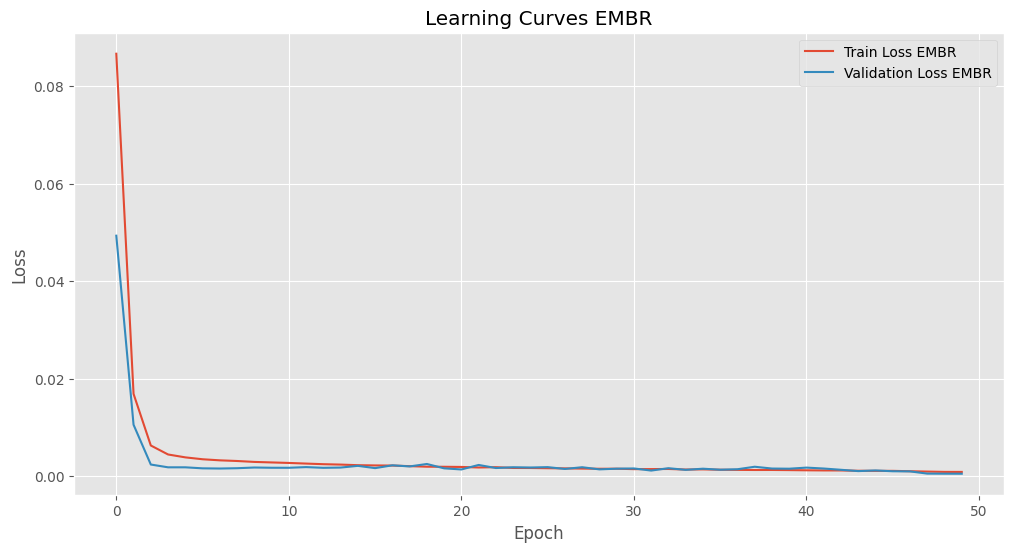

1/1 [==============================] - 0s 33ms/step


In [21]:
# Renamed variables
r_2 = 10
p_2 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_2(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_2(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(1, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_2(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Função para fazer previsões
def make_predictions_2(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data


# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_2 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_2 = MinMaxScaler()
normalized_data_2 = scaler_2.fit_transform(combined_data_2)

# Dividir os dados em treinamento e teste
train_size_2 = int(0.8 * normalized_data_2.shape[0])
train_data_2 = normalized_data_2[:train_size_2]
test_data_2 = normalized_data_2[train_size_2:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_2 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_2, y_train_2 = create_narmax_samples_2(train_data_2, sequence_length_2)
X_test_2, y_test_2 = create_narmax_samples_2(test_data_2, sequence_length_2)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR com learning curves
model_petr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_petr_2, X_train_2, y_train_2[:, 0], X_test_2, y_test_2[:, 0], label='PETR')

model_vale_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_vale_2, X_train_2, y_train_2[:, 1], X_test_2, y_test_2[:, 1], label='VALE')

model_embr_2 = create_narmax_model_2(r_2, p_2, sequence_length_2, normalized_data_2.shape[1])
train_narmax_model_with_learning_curves_2(model_embr_2, X_train_2, y_train_2[:, 2], X_test_2, y_test_2[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_2 = normalized_data_2[-sequence_length_2:, :]

predicted_2 = make_predictions_2([model_petr_2,
                              model_vale_2,
                              model_embr_2],
                              last_10_days_2, 90)

# Imprima as previsões
petr_predictions_2 = []
embr_predictions_2 = []
vale_predictions_2 = []

for i in predicted_2:
    petr_predictions_2.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_2.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_2.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [ ]:
plot_model(model_petr_2, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [22]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_2)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_2)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_2)

Previsão para os próximos 90 dias de PETR:
[11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05, 11.05]
Previsão para os próximos 90 dias de VALE:
[90.69201473273509, 86.44508542658221, 83.9630937101807, 80.70824387001818, 78.42133413122451, 77.1108379857688, 75.95566649622657, 75.10917473600307, 74.32630729985357, 73.39202158846322, 72.29675466089546, 70.80475934370858, 69.44543974452608, 68.26496126334399, 67.23818335211465,

<a name='ana'></a>
###[3] 10-10-10-3 --- r=10 , p=10, relu / Resilient Backpropapation

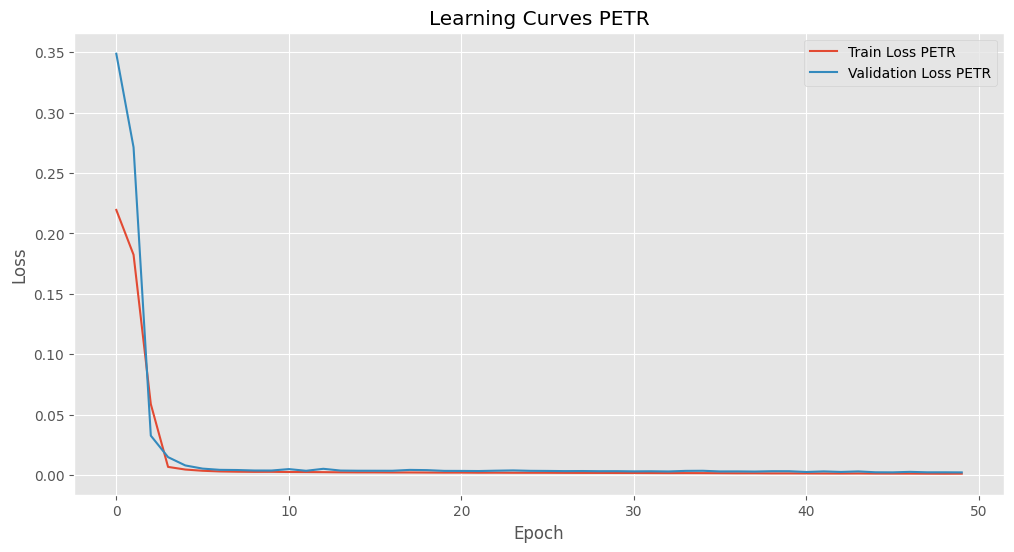

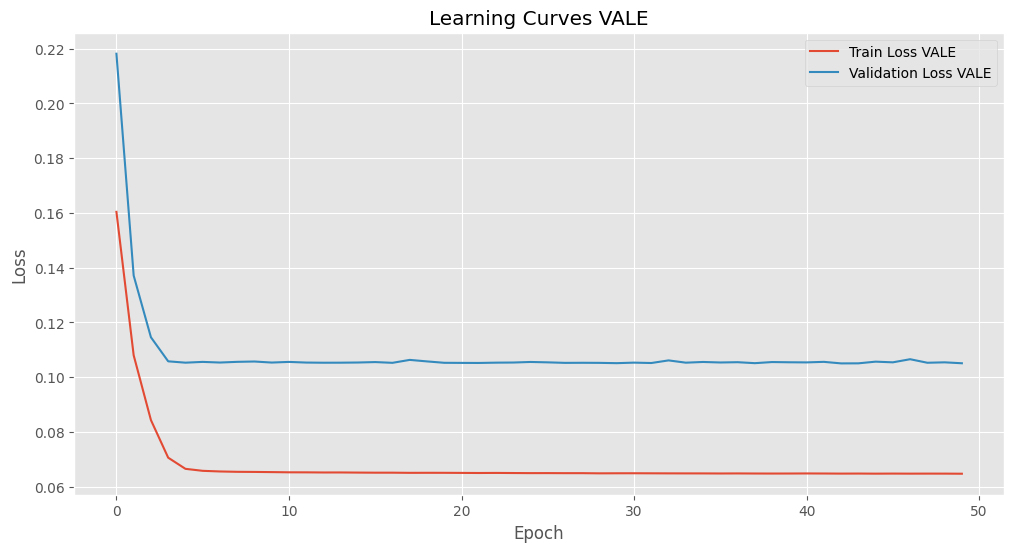

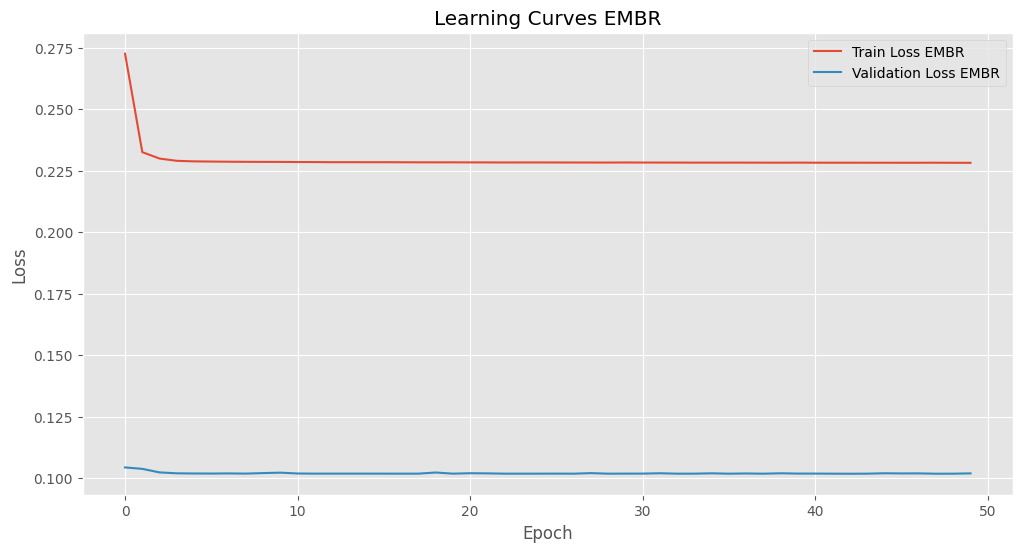

1/1 [==============================] - 0s 39ms/step


In [23]:
# Renamed variables
r_3 = 10
p_3 = 10

# Função para criar amostras NARMAX
def create_narmax_samples_3(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_3(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(p, activation='relu'),
        tf.keras.layers.Dense(3, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_3(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.001, rho=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

#Função para prever
def make_predictions_3(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_3 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_3 = MinMaxScaler()
normalized_data_3 = scaler_3.fit_transform(combined_data_3)

# Dividir os dados em treinamento e teste
train_size_3 = int(0.8 * normalized_data_3.shape[0])
train_data_3 = normalized_data_3[:train_size_3]
test_data_3 = normalized_data_3[train_size_3:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_3 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_3, y_train_3 = create_narmax_samples_3(train_data_3, sequence_length_3)
X_test_3, y_test_3 = create_narmax_samples_3(test_data_3, sequence_length_3)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_3
model_petr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_petr_3, X_train_3, y_train_3[:, 0], X_test_3, y_test_3[:, 0], label='PETR')

model_vale_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_vale_3, X_train_3, y_train_3[:, 1], X_test_3, y_test_3[:, 1], label='VALE')

model_embr_3 = create_narmax_model_3(r_3, p_3, sequence_length_3, normalized_data_3.shape[1])
train_narmax_model_with_learning_curves_3(model_embr_3, X_train_3, y_train_3[:, 2], X_test_3, y_test_3[:, 2], label='EMBR')


# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_3 = normalized_data_3[-sequence_length_3:, :]

predicted_3 = make_predictions_3([model_petr_3,
                              model_vale_3,
                              model_embr_3],
                              last_10_days_3, 90)

# Imprima as previsões
petr_predictions_3 = []
embr_predictions_3 = []
vale_predictions_3 = []

for i in predicted_3:
    petr_predictions_3.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_3.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_3.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [ ]:
plot_model(model_petr_3, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [24]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_3)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_3)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_3)

Previsão para os próximos 90 dias de PETR:
[26.926134805689156, 26.07670217740944, 25.735689974459916, 25.29818342953724, 24.800450550691338, 24.283227493277224, 23.765363401298583, 23.276663199564723, 22.83369922278917, 22.43909016536316, 22.090794718637973, 21.82330690706724, 21.607917474849103, 21.413786749182165, 21.223377661065012, 21.030548099173725, 20.835545384645254, 20.642462136734814, 20.45052365835166, 20.262731446087987, 20.078350810684025, 19.896104229355156, 19.71776932277322, 19.54209039060685, 19.3692056417267, 19.200061625042945, 19.03464742932895, 18.87324220013267, 18.7161032605488, 18.56207538445787, 18.410088362381234, 18.26180479247667, 18.116959168229506, 17.97554603402643, 17.83779998123999, 17.703633265422702, 17.572916770392776, 17.445682320561215, 17.322097676037462, 17.201970981086596, 17.085357246476217, 16.972284204907343, 16.8628400554619, 16.757040710345386, 16.65502937940733, 16.55677378360228, 16.462425316199734, 16.372135370469184, 16.285970323039294

<a name='ana'></a>
###[4] 10-25-10 ---  r=25 (RELU) / Polak-Ribiére Conjugate Gradient

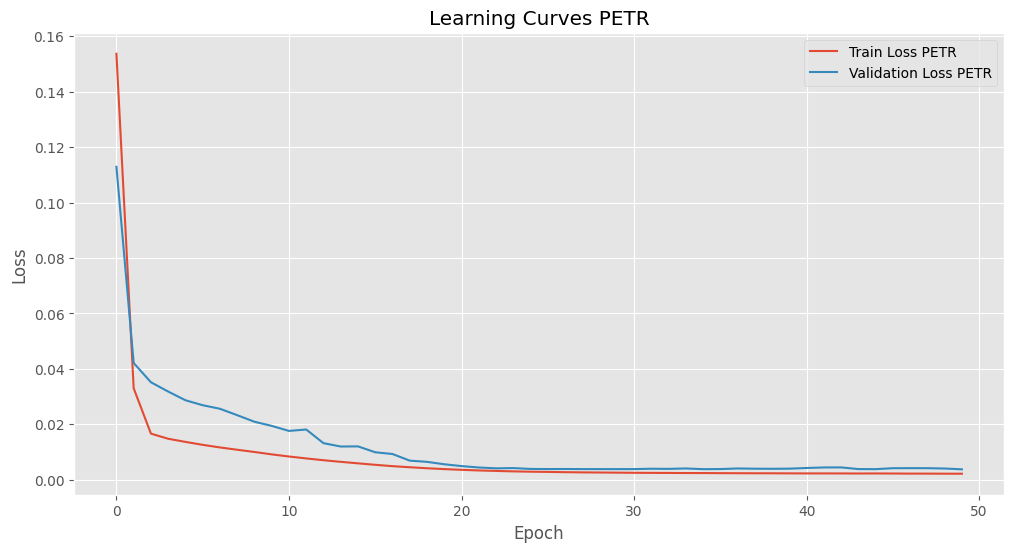

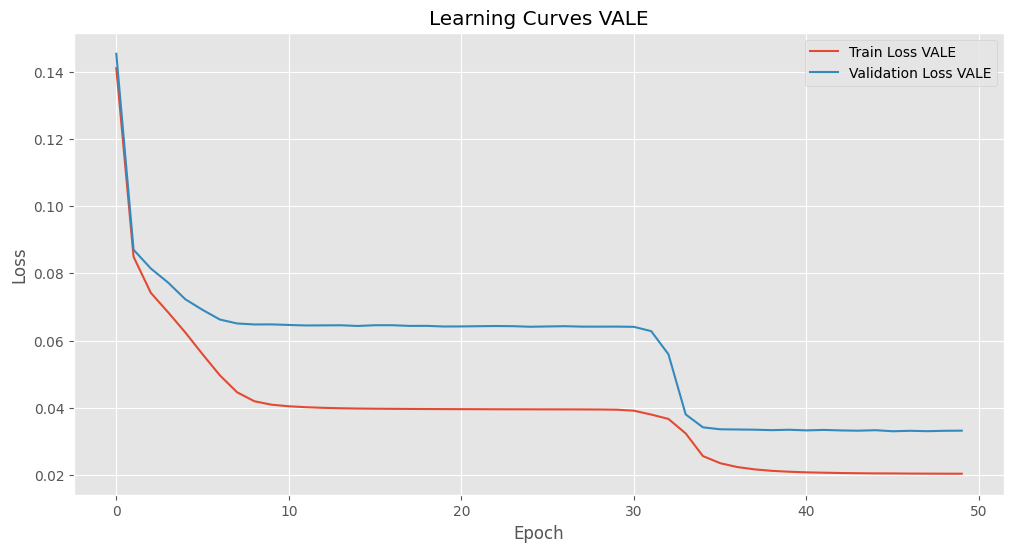

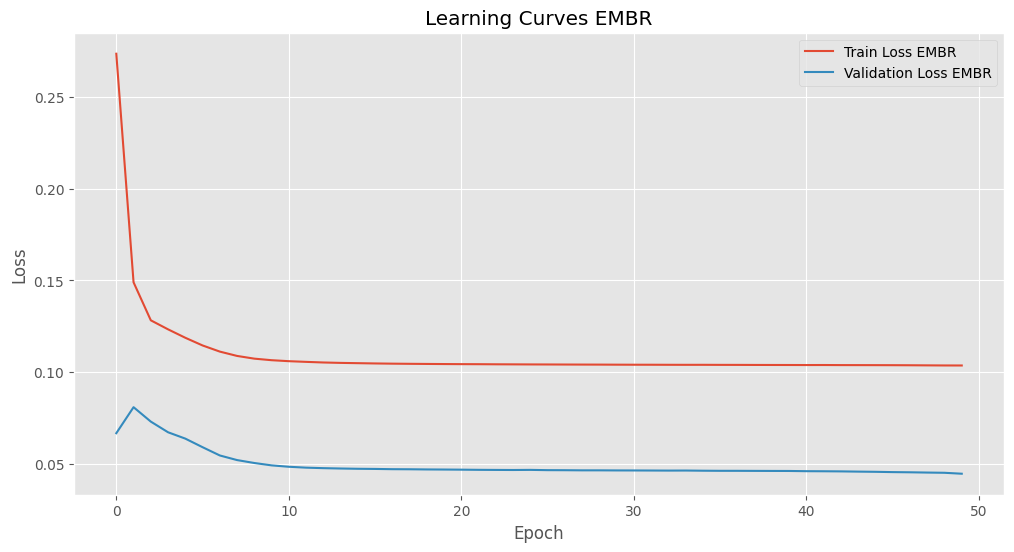

1/1 [==============================] - 0s 30ms/step


In [25]:
# Renamed variables
r_4 = 25
p_4 = 0

# Função para criar amostras NARMAX
def create_narmax_samples_4(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_4(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='relu', input_shape=(sequence_length, num_features)),
        tf.keras.layers.Dense(10, activation='relu')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_4(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    optimizer = tf.keras.optimizers.SGD(learning_rate=0.01, momentum=0.9)
    model.compile(optimizer=optimizer, loss='mse')
    history = model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss ' + label)
    plt.plot(history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    
# Função para fazer previsões
def make_predictions_4(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data


# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_4 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_4 = MinMaxScaler()
normalized_data_4 = scaler_4.fit_transform(combined_data_4)

# Dividir os dados em treinamento e teste
train_size_4 = int(0.8 * normalized_data_4.shape[0])
train_data_4 = normalized_data_4[:train_size_4]
test_data_4 = normalized_data_4[train_size_4:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_4 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_4, y_train_4 = create_narmax_samples_4(train_data_4, sequence_length_4)
X_test_4, y_test_4 = create_narmax_samples_4(test_data_4, sequence_length_4)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_cgp_4
model_petr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_petr_4, X_train_4, y_train_4[:, 0], X_test_4, y_test_4[:, 0], label='PETR')

model_vale_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_vale_4, X_train_4, y_train_4[:, 1], X_test_4, y_test_4[:, 1], label='VALE')

model_embr_4 = create_narmax_model_4(r_4, p_4, sequence_length_4, normalized_data_4.shape[1])
train_narmax_model_with_learning_curves_4(model_embr_4, X_train_4, y_train_4[:, 2], X_test_4, y_test_4[:, 2], label='EMBR')


# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_4 = normalized_data_4[-sequence_length_4:, :]

predicted_4 = make_predictions_4([model_petr_4,
                              model_vale_4,
                              model_embr_4],
                              last_10_days_4, 90)

# Imprima as previsões
petr_predictions_4 = []
embr_predictions_4 = []
vale_predictions_4 = []

for i in predicted_4:
    petr_predictions_4.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_4.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_4.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [ ]:
plot_model(model_petr_4, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [26]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_4)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_4)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_4)

Previsão para os próximos 90 dias de PETR:
[26.44497335228789, 26.037689086593122, 25.836426055785566, 25.672601262084036, 25.51436665349272, 25.347745857967197, 25.20406500716281, 25.08773860152036, 24.985574058775036, 24.904958279355498, 24.842067787596733, 24.73381750819841, 24.63877981498039, 24.54692456286284, 24.45874002923748, 24.372354938737214, 24.287380124278904, 24.203041798040687, 24.118788943077746, 24.03375320760408, 23.94909209091139, 23.865863072713914, 23.784646266560824, 23.704922479918302, 23.626727174272894, 23.55009217403561, 23.47508203729734, 23.401814969013245, 23.330262781847864, 23.260440024103374, 23.19237306457746, 23.126111003789962, 23.06160928756547, 22.99882518026635, 22.937745042859316, 22.878354327042192, 22.820610297177346, 22.764512043995886, 22.71004683773342, 22.657201948625534, 22.605947370799008, 22.55626764668277, 22.50813004259694, 22.46151182681936, 22.41638572128347, 22.37272353865379, 22.33049345451933, 22.28966819081351, 22.25021501385644, 

<a name='ana'></a>
###[5] 6-25-25-2 --- r=p=25 Tanh / Bayesian Regularization

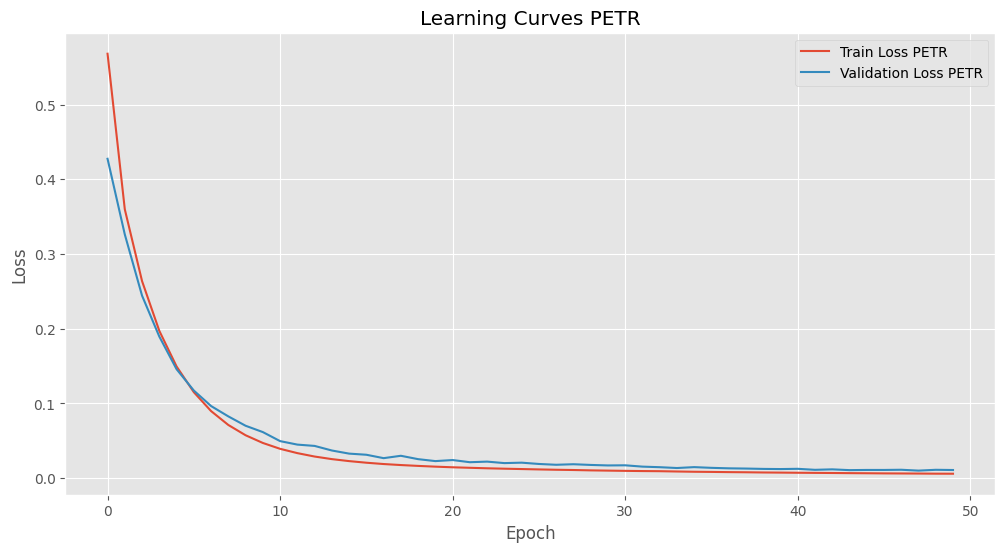

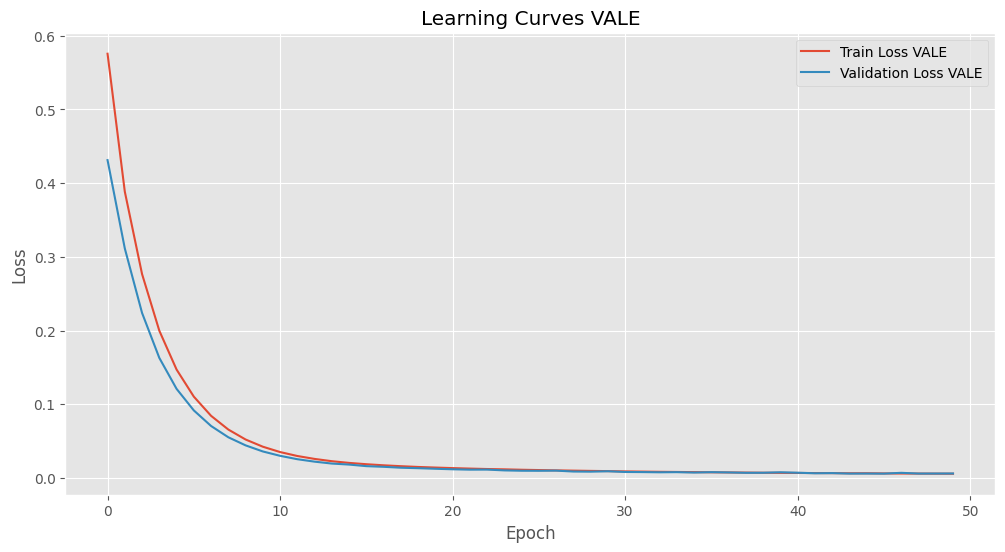

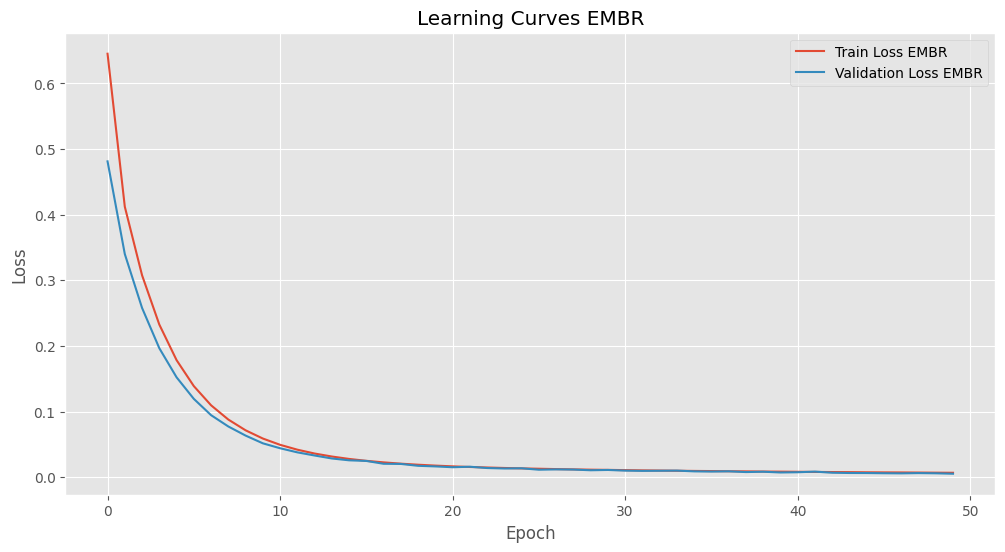

1/1 [==============================] - 0s 48ms/step


In [27]:
# Renamed variables
r_5 = 25
p_5 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_5(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX com Bayesian Regularization
def create_narmax_model_5(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
        tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features),
                             kernel_regularizer=tf.keras.regularizers.L2(0.01),
                             recurrent_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(p, activation='tanh', kernel_regularizer=tf.keras.regularizers.L2(0.01)),
        tf.keras.layers.Dense(2, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_5(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(model.history.history['loss'], label='Train Loss ' + label)
    plt.plot(model.history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Função para fazer previsões
def make_predictions_5(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data

# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_5 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_5 = MinMaxScaler()
normalized_data_5 = scaler_5.fit_transform(combined_data_5)

# Dividir os dados em treinamento e teste
train_size_5 = int(0.8 * normalized_data_5.shape[0])
train_data_5 = normalized_data_5[:train_size_5]
test_data_5 = normalized_data_5[train_size_5:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_5 = 6

# Crie amostras NARMAX para treinamento e teste
X_train_5, y_train_5 = create_narmax_samples_5(train_data_5, sequence_length_5)
X_test_5, y_test_5 = create_narmax_samples_5(test_data_5, sequence_length_5)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_br_5
model_petr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_petr_5, X_train_5, y_train_5[:, 0], X_test_5, y_test_5[:, 0], label='PETR')

model_vale_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_vale_5, X_train_5, y_train_5[:, 1], X_test_5, y_test_5[:, 1], label='VALE')

model_embr_5 = create_narmax_model_5(r_5, p_5, sequence_length_5, normalized_data_5.shape[1])
train_narmax_model_with_learning_curves_5(model_embr_5, X_train_5, y_train_5[:, 2], X_test_5, y_test_5[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_5 = normalized_data_5[-sequence_length_5:, :]

predicted_5 = make_predictions_5([model_petr_5,
                              model_vale_5,
                              model_embr_5],
                              last_10_days_5, 90)

# Imprima as previsões
petr_predictions_5 = []
embr_predictions_5 = []
vale_predictions_5 = []

for i in predicted_5:
    petr_predictions_5.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_5.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_5.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [ ]:
plot_model(model_petr_5, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [28]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_5)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_5)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_5)

Previsão para os próximos 90 dias de PETR:
[26.547289742937146, 26.40824798198837, 26.317657522891047, 26.312712918689787, 26.320790863471686, 26.313598546584608, 26.398962528126063, 26.382001026329398, 26.38251203544325, 26.395876469527483, 26.410937599352717, 26.426175127341807, 26.444145917601766, 26.451723764496446, 26.463300575951102, 26.47675229984838, 26.490294950634244, 26.50357755051875, 26.516449160866856, 26.528373313035907, 26.540726640119075, 26.553069055975616, 26.565175061921835, 26.577028291117788, 26.588643291865647, 26.600032793929813, 26.611296816887737, 26.62233715969974, 26.6331229072237, 26.643654059459628, 26.65393970909637, 26.663990767360566, 26.673807234252216, 26.683380017082452, 26.692709115851283, 26.701792712020932, 26.71063626120472, 26.719236126327097, 26.727599581539152, 26.73572662684089, 26.74362089930785, 26.751282398940027, 26.75872203696406, 26.765937994842172, 26.772935728187683, 26.779718874076128, 26.78629288812083, 26.792659588859557, 26.798829

<a name='ana'></a>
###[6] 10-25-25-1, r = p = 25, Tanh / RMSprop

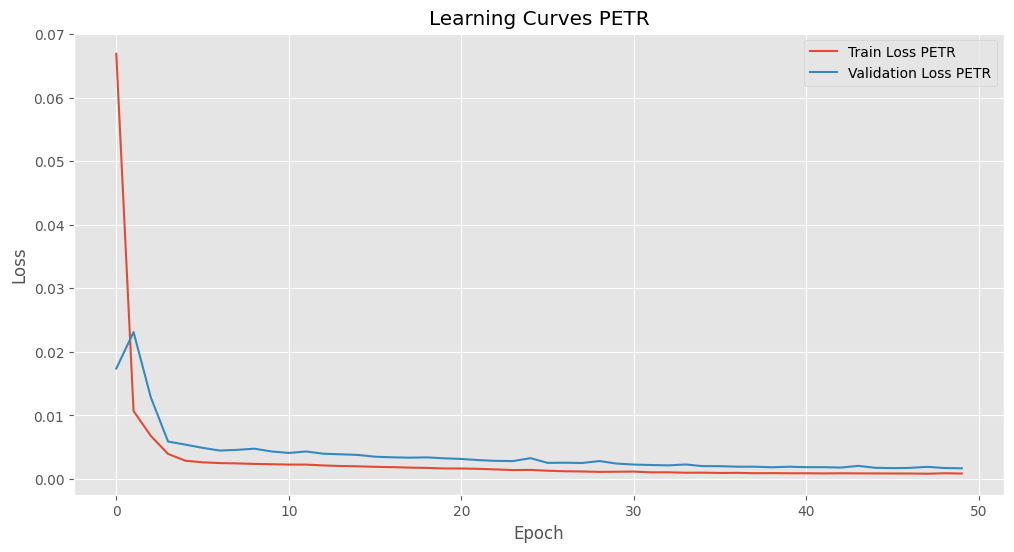

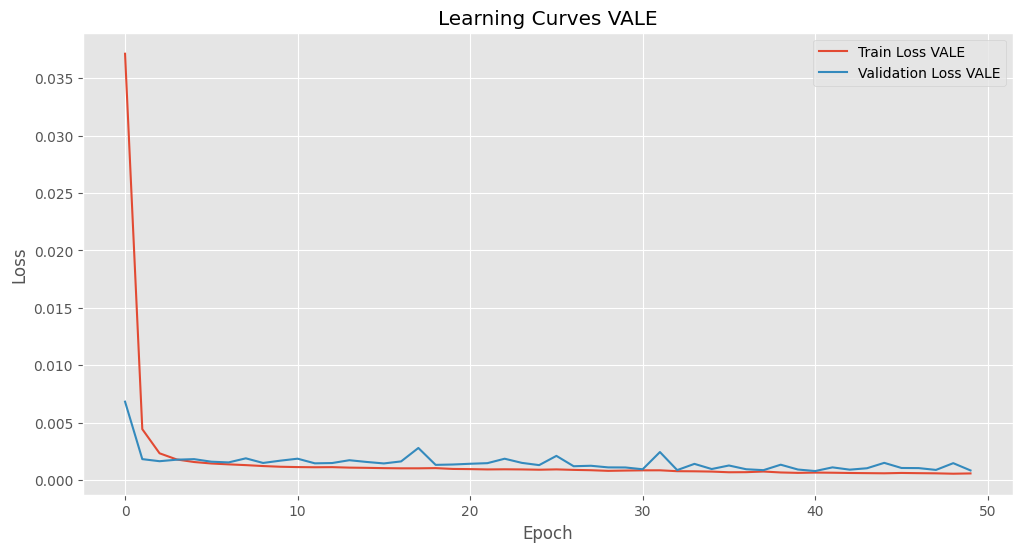

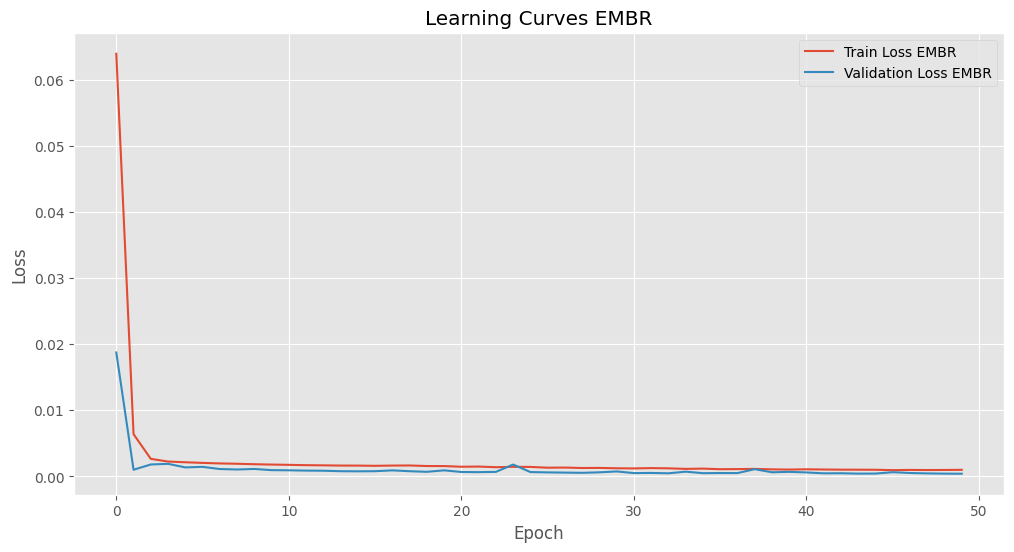

1/1 [==============================] - 0s 27ms/step


In [29]:
# Renamed variables
r_6 = 25
p_6 = 25

# Função para criar amostras NARMAX
def create_narmax_samples_6(data, sequence_length):
    X, y = [], []
    for i in range(len(data) - sequence_length):
        X.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(X), np.array(y)

# Função para criar um modelo NARMAX
def create_narmax_model_6(r, p, sequence_length, num_features):
    model = tf.keras.Sequential([
    tf.keras.layers.LSTM(r, activation='tanh', input_shape=(sequence_length, num_features)),
    tf.keras.layers.Dense(p, activation='tanh'),
    tf.keras.layers.Dense(1, activation='tanh')
    ])
    model.compile(optimizer='adam', loss='mse')
    return model

# Função para treinar um modelo NARMAX e plotar as learning curves
def train_narmax_model_with_learning_curves_6(model, X_train, y_train, X_test, y_test, num_epochs=50, label=''):
    model.fit(X_train, y_train, epochs=num_epochs, batch_size=32, validation_data=(X_test, y_test), verbose=0)
    
    # Plotar as learning curves
    plt.figure(figsize=(12, 6))
    plt.plot(model.history.history['loss'], label='Train Loss ' + label)
    plt.plot(model.history.history['val_loss'], label='Validation Loss ' + label)
    plt.title('Learning Curves ' + label)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

# Função para fazer previsões
def make_predictions_6(model, last_10_days, num_predictions):
    predicted_data = []
    for _ in range(num_predictions):
        prediction_petr = model[0].predict(np.array([last_10_days]))[0][0]
        prediction_embr = model[2].predict(np.array([last_10_days]))[0][0]
        prediction_vale = model[1].predict(np.array([last_10_days]))[0][0]
        prediction = [prediction_petr, prediction_embr, prediction_vale]
        predicted_data.append(prediction)
        last_10_days = np.concatenate((last_10_days[1:], [prediction]), axis=0)
    return predicted_data


# Combine os dados de fechamento em um único array (substitua pelas suas próprias variáveis)
combined_data_6 = np.column_stack((petr_close, vale_close, embr_close))

# Normalização dos dados
scaler_6 = MinMaxScaler()
normalized_data_6 = scaler_6.fit_transform(combined_data_6)

# Dividir os dados em treinamento e teste
train_size_6 = int(0.8 * normalized_data_6.shape[0])
train_data_6 = normalized_data_6[:train_size_6]
test_data_6 = normalized_data_6[train_size_6:]

# Defina o comprimento da sequência para a amostragem NARMAX
sequence_length_6 = 10

# Crie amostras NARMAX para treinamento e teste
X_train_6, y_train_6 = create_narmax_samples_6(train_data_6, sequence_length_6)
X_test_6, y_test_6 = create_narmax_samples_6(test_data_6, sequence_length_6)

# Crie e treine os modelos NARMAX para PETR, VALE e EMBR usando train_narmax_model_rp_6
model_petr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_petr_6, X_train_6, y_train_6[:, 0], X_test_6, y_test_6[:, 0], label='PETR')

model_vale_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_vale_6, X_train_6, y_train_6[:, 1], X_test_6, y_test_6[:, 1], label='VALE')

model_embr_6 = create_narmax_model_6(r_6, p_6, sequence_length_6, normalized_data_6.shape[1])
train_narmax_model_with_learning_curves_6(model_embr_6, X_train_6, y_train_6[:, 2], X_test_6, y_test_6[:, 2], label='EMBR')

# Previsão dos próximos 90 dias para PETR, VALE e EMBR
last_10_days_6 = normalized_data_6[-sequence_length_6:, :]

predicted_6 = make_predictions_6([model_petr_6,
                              model_vale_6,
                              model_embr_6],
                              last_10_days_6, 90)

# Imprima as previsões
petr_predictions_6 = []
embr_predictions_6 = []
vale_predictions_6 = []

for i in predicted_6:
    petr_predictions_6.append(i[0] * (np.max(petr_close) - np.min(petr_close)) + np.min(petr_close))
    embr_predictions_6.append(i[2] * (np.max(embr_close) - np.min(embr_close)) + np.min(embr_close))
    vale_predictions_6.append(i[1] * (np.max(vale_close) - np.min(vale_close)) + np.min(vale_close))

In [ ]:
plot_model(model_petr_6, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


In [30]:
print("Previsão para os próximos 90 dias de PETR:")
print(petr_predictions_6)

print("Previsão para os próximos 90 dias de VALE:")
print(vale_predictions_6)

print("Previsão para os próximos 90 dias de EMBR:")
print(embr_predictions_6)

Previsão para os próximos 90 dias de PETR:
[26.18672825894183, 26.449723372947574, 26.71121273767835, 26.978099522515535, 27.279576714308263, 27.600605005684553, 27.94068975437051, 28.28844145830196, 28.646422437199234, 29.013447004435182, 29.358359970905006, 29.70860489012146, 30.037609288164436, 30.351898078558804, 30.652836983171106, 30.939624026844026, 31.210595247516455, 31.464741356725096, 31.70142768478763, 31.920672417081775, 32.12298838125915, 32.30845195590615, 32.47795604306871, 32.63263541031635, 32.773208380068894, 32.90038418205732, 33.01498479535442, 33.11792130738384, 33.210122990946886, 33.29251184469384, 33.365969859443965, 33.431339018185554, 33.489386743858276, 33.54083863303303, 33.58635299638319, 33.62654631821334, 33.66199507499712, 33.69323209830165, 33.7207211152587, 33.7448967563957, 33.76613727756917, 33.78478638241798, 33.80114776674998, 33.81549784830648, 33.82807849261111, 33.839100650045395, 33.848760722688674, 33.85722783455372, 33.864640194511175, 33.87

## Analisando os resultados

In [31]:
df = pd.DataFrame(petr_predictions_1, index=date_index)
df.columns = ['Petr-pred1']

df['Embr-pred1'] = embr_predictions_1
df['Vale-pred1'] = vale_predictions_1
df['Petr-pred2'] = petr_predictions_2
df['Embr-pred2'] = embr_predictions_2
df['Vale-pred2'] = vale_predictions_2
df['Petr-pred3'] = petr_predictions_3
df['Embr-pred3'] = embr_predictions_3
df['Vale-pred3'] = vale_predictions_3
df['Petr-pred4'] = petr_predictions_4
df['Embr-pred4'] = embr_predictions_4
df['Vale-pred4'] = vale_predictions_4
df['Petr-pred5'] = petr_predictions_5
df['Embr-pred5'] = embr_predictions_5
df['Vale-pred5'] = vale_predictions_5
df['Petr-pred6'] = petr_predictions_6
df['Embr-pred6'] = embr_predictions_6
df['Vale-pred6'] = vale_predictions_6

df = df.reset_index()
df['Date'] = pd.to_datetime(df.Date, format = '%d/%m/%Y')

df

,Date,Petr-pred1,Embr-pred1,Vale-pred1,Petr-pred2,Embr-pred2,Vale-pred2,Petr-pred3,Embr-pred3,Vale-pred3,Petr-pred4,Embr-pred4,Vale-pred4,Petr-pred5,Embr-pred5,Vale-pred5,Petr-pred6,Embr-pred6,Vale-pred6
0,2023-03-21,27.390606,18.600575,91.141690,11.05,18.058906,90.692015,26.926135,17.769194,34.099998,26.444973,17.810409,34.099998,26.547290,18.685305,88.789464,26.186728,17.632923,92.006026
1,2023-03-22,27.458390,18.706189,90.119247,11.05,17.812313,86.445085,26.076702,15.166489,34.099998,26.037689,15.678888,34.099998,26.408248,18.809108,88.678415,26.449723,18.471162,88.899069
2,2023-03-23,27.521168,18.877425,88.994144,11.05,17.422320,83.963094,25.735690,13.048614,34.099998,25.836426,13.944613,34.099998,26.317658,18.983191,88.304931,26.711213,18.885906,87.377185
3,2023-03-24,27.589839,19.075432,88.243206,11.05,17.153614,80.708244,25.298183,11.274316,34.099998,25.672601,12.487644,34.099998,26.312713,19.258051,88.035000,26.978100,19.037999,86.836157
4,2023-03-27,27.670017,19.288797,88.100095,11.05,16.845749,78.421334,24.800451,9.731291,34.099998,25.514367,11.274997,34.099998,26.320791,19.512902,87.691778,27.279577,19.057459,86.918895
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
85,2023-07-24,31.103462,22.067131,99.320138,11.05,10.008913,52.171117,14.769083,6.673460,34.099998,21.477166,8.349589,38.476460,26.925613,20.435938,90.943102,33.917931,19.090236,87.057694
86,2023-07-25,31.107202,22.067908,99.323275,11.05,9.999370,52.130414,14.753958,6.674926,34.099998,21.468352,8.349707,38.477108,26.927211,20.435999,90.943274,33.918007,19.090100,87.057053
87,2023-07-26,31.110794,22.068620,99.326165,11.05,9.990155,52.091103,14.739522,6.675872,34.099998,21.459905,8.349820,38.477726,26.928754,20.436058,90.943425,33.918082,19.089974,87.056468
88,2023-07-27,31.114235,22.069281,99.328808,11.05,9.981254,52.053133,14.725723,6.676745,34.099998,21.451813,8.349929,38.478321,26.930237,20.436106,90.943561,33.918149,19.089858,87.055923


In [32]:
colors = [
    '#003f5c',
    '#444e86',
    '#955196',
    '#dd5182',
    '#ff6e54',
    '#ffa600',
]
indice = 'Petr'
fig = go.Figure()
# Create and style traces
fig.add_trace(go.Scatter(x=companies[indice].index, y=companies[indice].Close, name = 'Real Close',
                         line=dict(color='royalblue', width=1)))

for i in range(0, 6):
    pred = df.loc[:, df.columns.str.startswith(indice)].columns[i]
    fig.add_trace(go.Scatter(x=df.Date, y=df[pred], name=pred,
                            line=dict(color = colors[i])
                            )
                )

layout = dict(
        title=f'Real close and Predicition for {indice}',
        xaxis=dict(
            rangeselector=dict(
                buttons=list([
                    #change the count to desired amount of months.
                    dict(count=1,
                         label='1m',
                         step='month',
                         stepmode='backward'),
                    dict(count=3,
                         label='3m',
                         step='month',
                         stepmode='backward'),
                    dict(count=5,
                         label='5m',
                         step='month',
                         stepmode='backward'),
                    dict(count=6,
                         label='6m',
                         step='month',
                         stepmode='backward'),      
                    dict(count=12,
                         label='1y',
                         step='month',
                         stepmode='backward'),                                               
                    dict(step='all')
                ])
            ),
            rangeslider=dict(
                visible = True
            ),
            type='date'
        )
    )

fig.layout = layout
fig.show()